In [1]:
import numpy as np
import pandas as pd
from epiweeks import Week
from itertools import product
import matplotlib.pyplot as plt
from tensorflow.keras.activations import gelu 
from time import time
import tensorflow as tf
from keras import layers
import keras.backend as K
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM,  Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler

In [2]:
code_to_state = {33: 'RJ', 32: 'ES', 41: 'PR', 23: 'CE', 21: 'MA',
 31: 'MG', 42: 'SC', 26: 'PE', 25: 'PB', 24: 'RN', 22: 'PI', 27: 'AL',
 28: 'SE', 35: 'SP', 43: 'RS', 15: 'PA', 16: 'AP', 14: 'RR',  11: 'RO',
 13: 'AM', 12: 'AC', 51: 'MT', 50: 'MS', 52: 'GO', 17: 'TO', 53: 'DF',
 29: 'BA'}

In [3]:
def transform_label(ep_label): 
    year_ep_label = int(ep_label[:4])
    week_ep_label = int(ep_label[4:])
    
    if week_ep_label <=40:
        new_week = 12 + week_ep_label
        new_year = year_ep_label
    
    else:
        new_week = week_ep_label - 40
        new_year = year_ep_label +1
    
    if new_week <=9:
        week_str = f'0{new_week}'
    else:
        week_str = str(new_week)

    new_ep_label = f'{new_year}{week_str}'

    return new_ep_label


def add_ep_label(df_w):
    '''
    This function assumes that the dataframe has a datetime index
    '''

    df_w['epiweek_label'] = [Week.fromdate(x) for x in df_w.index]
    
    df_w['epiweek_label'] = df_w['epiweek_label'].astype(str)
    
    df_w['epiweek_label'] = df_w['epiweek_label'].apply(transform_label)
    
    
    df_w['epiweek'] = df_w['epiweek_label'].astype(str).str[-2:].astype(int)
    df_w['year'] = df_w['epiweek_label'].astype(str).str[:4].astype(int)

    return df_w

In [4]:
state = 'MG'

In [5]:
df = pd.read_csv('./data/dengue.csv.gz', usecols = ['date', 'epiweek', 'geocode', 'casos', 'regional_geocode', 'uf'])

df = df.loc[df.uf == state]

del df['uf']

df.date = pd.to_datetime(df.date)

#df.set_index('date', inplace = True)
df = df.loc[df.epiweek.astype(str).str[-2:].astype(int) != 53]

df.head()

,date,epiweek,casos,geocode,regional_geocode
801,2010-01-03,201001,0,3110806,31096
802,2010-01-03,201001,0,3132404,31003
803,2010-01-03,201001,0,3168903,31082
804,2010-01-03,201001,0,3155405,31097
805,2010-01-03,201001,0,3170602,31093


In [6]:
df_climate = pd.read_csv('./data/climate.csv.gz', usecols = [
    'date', 'epiweek', 'geocode', 'temp_min', 'temp_med', 'temp_max', 'rel_humid_med', 'precip_tot']) 

df_climate['uf'] = df_climate.geocode.astype(str).str[:2].astype(int)

df_climate['uf'] = df_climate['uf'].replace(code_to_state)

df_climate = df_climate.loc[df_climate.uf == 'MG']

df_climate.date = pd.to_datetime(df_climate.date)

del df_climate['uf']

df_climate = df_climate.loc[df_climate.epiweek.astype(str).str[-2:].astype(int) != 53]

df_climate['temp_amp'] = df_climate['temp_max'] - df_climate['temp_min']

df_climate.head()

,date,epiweek,geocode,temp_min,temp_med,temp_max,precip_tot,rel_humid_med,temp_amp
2244,2009-12-27,200952,3100104,20.7208,23.4406,27.3525,5.5421,84.8923,6.6317
2245,2009-12-27,200952,3100203,21.2028,24.3718,28.6233,0.8166,79.5011,7.4205
2246,2009-12-27,200952,3100302,20.0611,23.8270,28.7545,0.9051,78.3925,8.6934
2247,2009-12-27,200952,3100401,18.9060,22.3913,27.7191,2.7522,79.8940,8.8131
2248,2009-12-27,200952,3100500,20.1577,24.5404,29.9290,0.5607,75.4242,9.7713


In [7]:
%%time 

df_end = df.merge(df_climate, left_on = ['date', 'epiweek', 'geocode'], right_on = ['date', 'epiweek', 'geocode'])

df_end.date = pd.to_datetime(df_end.date)

df_end.set_index('date', inplace = True)

df_end.head()

CPU times: user 103 ms, sys: 59.8 ms, total: 163 ms
Wall time: 169 ms


,epiweek,casos,geocode,regional_geocode,temp_min,temp_med,temp_max,precip_tot,rel_humid_med,temp_amp
date,,,,,,,,,,
2010-01-03,201001,0,3110806,31096,21.9829,26.5957,32.0409,0.1879,69.7659,10.0580
2010-01-03,201001,0,3132404,31003,18.5711,22.3066,27.3997,3.1666,78.2605,8.8286
2010-01-03,201001,0,3168903,31082,19.2286,23.4808,28.1682,1.6369,75.2743,8.9396
2010-01-03,201001,0,3155405,31097,22.1361,26.4140,31.8807,0.9042,75.2398,9.7446
2010-01-03,201001,0,3170602,31093,19.4717,23.8841,28.7656,0.7958,73.9370,9.2939


In [8]:
def agg_data(df, geocode = None, column = 'geocode'):

    if geocode is not None: 

        df = df.loc[df[column] == geocode]
        
    df_w = df[['casos', 'temp_med', 'temp_amp', 'rel_humid_med', 'precip_tot']]

    df_w = df_w.resample('W-SUN').agg({'casos': 'sum',  
                                      'temp_med':'mean', 
                                      'temp_amp':'mean', 
                                      'rel_humid_med':'mean',
                                      'precip_tot': 'sum'})

    df_w = add_ep_label(df_w)
    
    return df_w




In [9]:
df_w = agg_data(df_end)

df_w.head()

,casos,temp_med,temp_amp,rel_humid_med,precip_tot,epiweek_label,epiweek,year
date,,,,,,,,
2010-01-03,2794,24.493388,9.483588,74.979549,1018.4501,201013,13,2010
2010-01-10,3729,24.900527,9.352005,72.909427,954.9665,201014,14,2010
2010-01-17,4656,24.580101,9.402882,72.142172,896.7963,201015,15,2010
2010-01-24,6195,24.292453,8.994087,72.184517,944.5322,201016,16,2010
2010-01-31,7179,25.504058,10.434867,66.225272,276.2967,201017,17,2010


In [10]:
enso = pd.read_csv('./data/enso.csv.gz')

iod = pd.read_csv('./data/iod.csv.gz')

enso = enso.merge(iod, right_on = 'date', left_on = 'date')

pdo = pd.read_csv('https://raw.githubusercontent.com/eduardocorrearaujo/baseline_week/main/data/pdo.csv', index_col = 'Unnamed: 0')
enso = enso.merge(pdo, right_on = 'date', left_on = 'date')

enso.date = pd.to_datetime(enso.date)

enso.set_index('date', inplace = True)

enso = enso.loc[enso.index.year >= 2010]

enso = enso.resample('W-SUN').mean()  # Resample to monthly frequency and calculate mean
enso = enso.fillna(method='ffill')

enso = add_ep_label(enso)

enso.head()

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_76190/2178504581.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  enso = enso.fillna(method='ffill')


,enso,iod,pdo,epiweek_label,epiweek,year
date,,,,,,
2010-01-10,1.230226,-0.419708,-0.115554,201014,14,2010
2010-01-17,1.070318,-0.443917,0.061606,201015,15,2010
2010-01-24,0.957734,-0.154522,0.207900,201016,16,2010
2010-01-31,1.210819,-0.069680,0.385610,201017,17,2010
2010-02-07,1.210819,-0.069680,0.385610,201018,18,2010


In [11]:
def get_train_data(df_w): 

    columns_to_normalize = ['casos', 'temp_med', 'temp_amp', 'rel_humid_med', 'precip_tot', 'enso', 'iod', 'pdo']

    norm_values = df_w.max()[columns_to_normalize]
    
    df_w[columns_to_normalize] = df_w[columns_to_normalize]/norm_values
    
    min_year = 2014

    X_train = np.empty((0, 52, 19))
    
    y_train = np.empty((0, 52))
        
    for year in np.arange(min_year, df_w.index.year.max()+1): 
        
        last_values = df_w.loc[df_w.year <= year - 1][['epiweek', 'casos']].groupby('epiweek').mean().values.reshape(1, -1,1)

        for col in columns_to_normalize: 

            if (col == 'enso') or (col == 'iod') or (col=='pdo'):

                last_  = df_w.loc[df_w.year== year-1][col].values.reshape(1, -1,1)

            else:
        
                last_3 = df_w.loc[df_w.year == year-3][col].values.reshape(1, -1,1)
                last_2 = df_w.loc[df_w.year == year-2][col].values.reshape(1, -1,1)
                last_1 = df_w.loc[df_w.year == year-1][col].values.reshape(1, -1,1)

                last_ = np.concatenate((last_1, last_2, last_3), axis=2)

            last_values = np.concatenate((last_values, last_), axis=2)

        X_train = np.append(X_train, last_values, axis = 0)
            
        y_train = np.append(y_train, df_w.loc[df_w.year == year][['casos']].values.reshape(1,-1),
                                   axis = 0)


    return X_train.astype(np.float32), y_train.astype(np.float32), norm_values 


def get_test_data(norm_values, df_w, year): 

    columns_to_normalize = ['casos', 'temp_med', 'temp_amp', 'rel_humid_med', 'precip_tot', 'enso', 'iod', 'pdo']
    
    df_w[columns_to_normalize] = df_w[columns_to_normalize]/norm_values

    X_test = np.empty((0, 52, 19))
    
    y_test = np.empty((0, 52))

    last_values = df_w.loc[df_w.year <= year - 1][['epiweek', 'casos']].groupby('epiweek').mean().values.reshape(1, -1,1)

    for col in columns_to_normalize: 

        if (col == 'enso') or (col == 'iod') or (col=='pdo'):

                last_  = df_w.loc[df_w.year== year-1][col].values.reshape(1, -1,1)

        else:
        
            last_3 = df_w.loc[df_w.year == year-3][col].values.reshape(1, -1,1)
            last_2 = df_w.loc[df_w.year == year-2][col].values.reshape(1, -1,1)
            last_1 = df_w.loc[df_w.year == year-1][col].values.reshape(1, -1,1)

            last_ = np.concatenate((last_1, last_2, last_3), axis=2)

        last_values = np.concatenate((last_values, last_), axis=2)

    X_test = np.append(X_test, last_values, axis = 0)
        
    y_test = np.append(y_test, df_w.loc[df_w.year == year][['casos']].values.reshape(1,-1),
                               axis = 0)

    return X_test.astype(np.float32), y_test.astype(np.float32)

def make_preds(model, X_test, norm, dates):

    predicted = np.stack([model(X_test, training =True) for i in range(100)], axis=2)

    df_pred = pd.DataFrame(np.percentile(predicted, 50, axis=2))
    df_pred25 = pd.DataFrame(np.percentile(predicted, 2.5, axis=2))
    df_pred975 = pd.DataFrame(np.percentile(predicted, 97.5, axis=2))

    df_preds = pd.DataFrame()

    df_preds['lower'] = df_pred25.values.reshape(1,-1)[0]
    df_preds['preds'] = df_pred.values.reshape(1,-1)[0]
    df_preds['upper'] = df_pred975.values.reshape(1,-1)[0]

    df_preds = df_preds*norm['casos']

    df_preds['dates'] = pd.to_datetime(dates)

    return df_preds[['dates', 'lower', 'preds', 'upper']]

In [12]:
from keras.models import load_model

# Load the model
loaded_model = load_model('./saved_models/region_model_MG_2022.keras')

In [13]:
geo = 31011

df_w = agg_data(df_end, geo, column = 'regional_geocode')

data = df_w.merge(enso[['enso', 'iod', 'pdo']], left_index = True, right_index = True)

data = data.dropna()

X_train, y_train, norm_values = get_train_data(data.loc[data.year <= 2022])

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_76190/844966674.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w[columns_to_normalize] = df_w[columns_to_normalize]/norm_values


In [14]:
X_train.shape

(9, 52, 19)

In [15]:
df_preds = make_preds(loaded_model, X_train[0].reshape(1,52,19), norm_values, dates = df_w.loc[df_w.year == 2022].index.values)

df_preds.head()

,dates,lower,preds,upper
0,2021-10-10,0.0,0.0,0.0
1,2021-10-17,0.0,0.0,0.0
2,2021-10-24,0.0,0.0,0.0
3,2021-10-31,0.0,0.0,0.0
4,2021-11-07,0.0,0.0,0.0


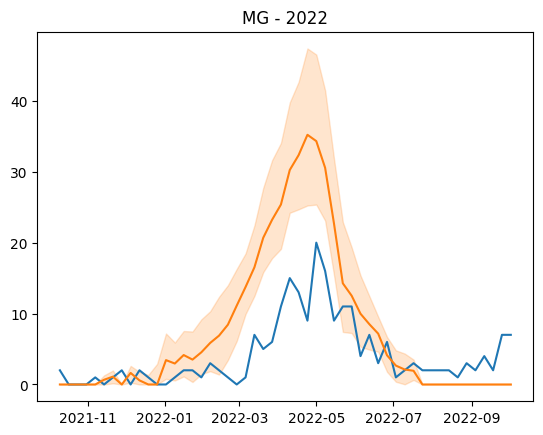

In [16]:
fig, ax = plt.subplots()

ax.plot(df_w.loc[df_w.year == 2022].index, y_train[0]*norm_values['casos'], label = 'Data')

ax.plot(df_preds.dates, df_preds.preds, label = 'preds')

ax.fill_between( df_preds.dates, df_preds.lower, df_preds.upper, color = 'tab:orange', alpha = 0.2)

ax.set_title(f'MG - 2022')

plt.show()

### Making the predictions for all the regions

In [16]:
%%time
predicted = np.zeros((1,52,100))
for geo in df.regional_geocode.unique():

    df_w = agg_data(df_end, geo, column = 'regional_geocode')

    data = df_w.merge(enso[['enso', 'iod']], left_index = True, right_index = True)

    data = data.dropna()

    X_train, y_train, norm_values = get_train_data(data.loc[data.year <= 2022])

    X_test, y_test = get_test_data(norm_values, data, year = 2023)

    predicted_ = np.stack([loaded_model(X_test.astype(np.float32), training =True) for i in range(100)], axis=2)

    predicted_ = predicted_*norm_values['casos']

    predicted = predicted + predicted_

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_16234/2901858127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w[columns_to_normalize] = df_w[columns_to_normalize]/norm_values
/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_16234/2901858127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w[columns_to_normalize] = df_w[columns_to_normalize]/norm_values
/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_16234/2901858127.py:7: SettingWithCopyWarning: 
A value is tr

CPU times: user 11min 27s, sys: 16.7 s, total: 11min 44s
Wall time: 11min 37s


In [17]:
predicted

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [6.59021664, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 1.18448973, ..., 0.        ,
         0.        , 0.        ]]])

In [18]:
df_pred = pd.DataFrame(np.percentile(predicted, 50, axis=2))
df_pred25 = pd.DataFrame(np.percentile(predicted, 2.5, axis=2))
df_pred975 = pd.DataFrame(np.percentile(predicted, 97.5, axis=2))

df_preds = pd.DataFrame()

df_preds['lower'] = df_pred25.values.reshape(1,-1)[0]
df_preds['preds'] = df_pred.values.reshape(1,-1)[0]
df_preds['upper'] = df_pred975.values.reshape(1,-1)[0]

df_preds.head()

,lower,preds,upper
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [19]:
df_w = agg_data(df_end)

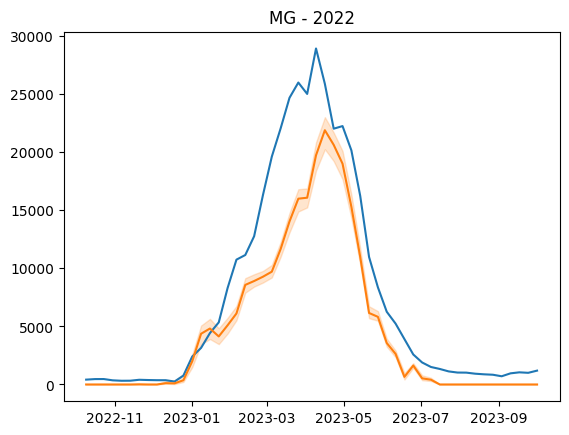

In [20]:
fig, ax = plt.subplots()

ax.plot(df_w.loc[df_w.year == 2023].casos, label = 'Data')

ax.plot(df_w.loc[df_w.year == 2023].index, df_preds.preds, label = 'preds')

ax.fill_between(df_w.loc[df_w.year == 2023].index, df_preds.lower, df_preds.upper, color = 'tab:orange', alpha = 0.2)

ax.set_title(f'MG - 2022')

plt.show()